## Лабораторная работа №1

> Мирошкина Ксения 3823М1ФИии3

--- 

### Цели работы

Цель — изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети (один скрытый слой).

---

### Задачи работы

> Выполнение работы предполагает решение следующих задач:

1. Изучение общей схемы работы метода обратного распространения ошибки с помощью стохастического градиентного спуска.
1. Вывод математических формул для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
1. Реализация и тестирование метода обратного распространения ошибки для классификации рукописных цифр из набора данных MNIST.

> Конфигурация нейронной сети:

1. Входной слой содержит w x h нейронов, что соответствует разрешению одноканального изображения (для изображений в базе MNIST составляет 28x28).
1. Выходной слой содержит k нейронов, что соответствует количеству классов изображений (для задачи классификации рукописных цифр MNIST – 10 классов).
1. Скрытый слой содержит s нейронов (параметр).
1. Скорость обучения (learning rate), размер пачки данных (batch size), количество эпох являются параметрами метода обучения.
1. В качестве функции активации на скрытом слое используется функция ReLU. В качестве функции активации на выходном слое используется функция softmax. Входной слой не содержит функцию активации.
1. В качестве функции ошибки используется кросс-энтропия. Функция активации softmax вместе с функцией ошибки кросс-энтропия упрощают вывод формул.
1. Набор параметров для демонстрации работы нейронной сети (и выложенные материалы и демонстрации в т/к выполняется на данных параметрах):
	* Размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти).
	* Скорость обучения - 0.1.
	* Количество скрытых нейронов s - 300.
	* Количество эпох – 20.

---

In [10]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import time

## Загрузка MNIST

In [11]:
def get_train_test_data():
    # Путь к данным
    path = './MNIST/' 
    
	 # Загрузка изображений
    x_train = idx2numpy.convert_from_file(path + 'train-images-idx3-ubyte')
    x_test = idx2numpy.convert_from_file(path + 't10k-images-idx3-ubyte')
    
	 # Загрузка меток классов
    y_train = idx2numpy.convert_from_file(path + 'train-labels-idx1-ubyte')
    y_test = idx2numpy.convert_from_file(path + 't10k-labels-idx1-ubyte')

    # Нормализация данных
    x_train = x_train.reshape(x_train.shape[0], 28 * 28) / 255
    x_test = x_test.reshape(x_test.shape[0], 28 * 28) / 255

    # One-hot encoding для меток
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    return x_train, x_test, y_train, y_test


## Проверка загрузки

In [12]:
def plot_mnist_samples(images, labels, num_samples=10):
     # Выбор случайных изображений
    indices = np.random.choice(len(images), size=num_samples, replace=False)
    images_to_plot = images[indices].reshape(-1, 28, 28)
    labels_to_plot = np.argmax(labels[indices], axis=1)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle('Примеры изображений из MNIST')
    
    for i, ax in enumerate(axes):
        ax.imshow(images_to_plot[i], cmap='gray')
        ax.set_title(f'Метка: {labels_to_plot[i]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

> Пример изображений из тренировочной выборки

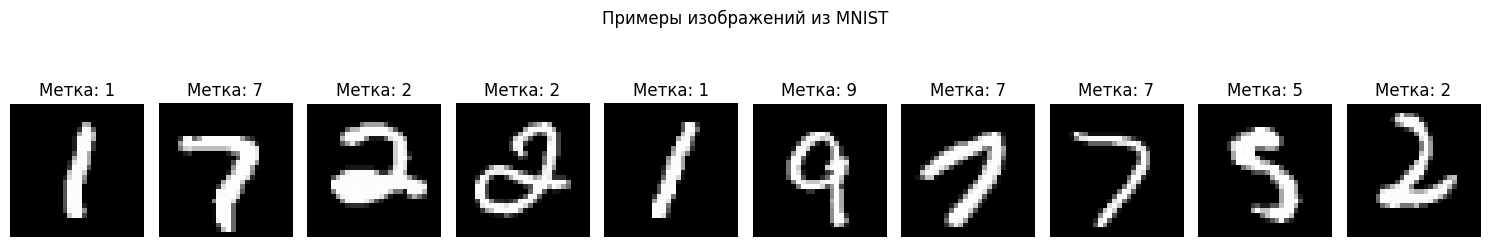

In [13]:
x_train, x_test, y_train, y_test = get_train_test_data()
plot_mnist_samples(x_train, y_train, 10)  

> Пример изображений из тестовой выборки

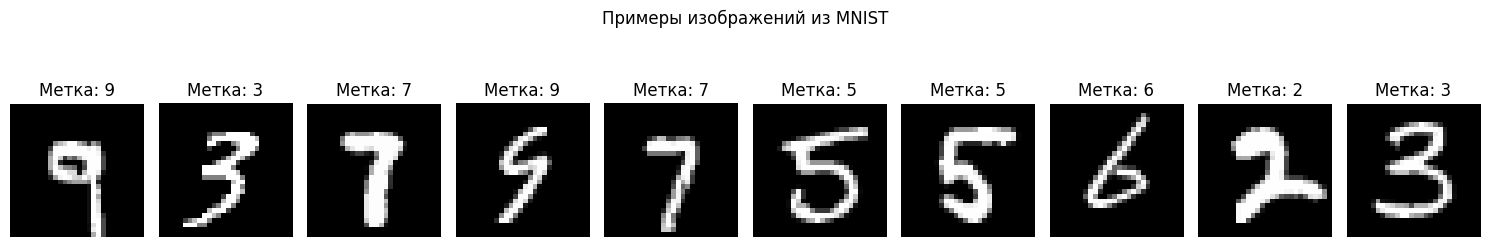

In [14]:
plot_mnist_samples(x_test, y_test, 10)

## Функции активации

In [15]:
# ReLU
def ReLU(x):
    return np.maximum(x, 0)

# Производная ReLU
def d_ReLU_dx(x):
    return np.where(x > 0, 1, 0)

# Softmax
def softmax(u):
    # Смещение значения
    shift = np.max(u, axis=-1, keepdims=True)
    # Расчет экспоненты
    u = np.exp(u - shift)
    return u / np.sum(u, axis=-1, keepdims=True)

# Функции потерь
def crossEntropyLoss(y, u):
    return np.mean(-np.sum(y * np.log(u), axis=1))

def accuracy(y, u):
    return np.mean(np.argmax(y, axis=1) == np.argmax(u, axis=1))



## Обратное распространение ошибки

In [16]:
def dE_dW1(u, y, v_transpose):
    # Вычисляем ошибку на выходном слое сети
    err_u = (u - y) / u.shape[0]
    dEdW1 = np.dot(v_transpose, err_u)
    return err_u, dEdW1

def dE_dW0(z0, err_u, x_transpose, w1_transpose):
    # Вычисляем ошибку на скрытом слое сети
    err_v = np.dot(err_u, w1_transpose) * d_ReLU_dx(z0)
    dEdW0 = np.dot(x_transpose, err_v)
    return err_v, dEdW0

## Модель

In [17]:
class NeuralNetwork:
    def __init__(self, input_size=28*28, hidden_size=300, output_size=10, learning_rate=0.1, batch_size=32):
        # Инициализация весов
        self.w0 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b0 = np.zeros((1, hidden_size))
        
        self.w1 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b1 = np.zeros((1, output_size))
        
		  # Параметры обучения
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def forward(self, x):
        # Прямое распространение
        self.z0 = np.dot(x, self.w0) + self.b0
        self.v = ReLU(self.z0)
        self.z1 = np.dot(self.v, self.w1) + self.b1
        self.u = softmax(self.z1)

    def backward(self, x, y):
        # Обратное распространение
        err_u, dEdW1 = dE_dW1(self.u, y, self.v.T)
        err_v, dEdW0 = dE_dW0(self.z0, err_u, x.T, self.w1.T)

        # Обновление весов
        # для входного - скрытого
        self.w0 -= self.learning_rate * dEdW0
        # для скрытого - выходного
        self.w1 -= self.learning_rate * dEdW1
        # Обновление смещений
        self.b0 -= self.learning_rate * np.sum(err_v, axis=0, keepdims=True)
        self.b1 -= self.learning_rate * np.sum(err_u, axis=0, keepdims=True)

    def train_one_epoch(self, x_train, y_train):
        # Обучение одной эпохи
        i = 0
        while i < len(x_train):
            x_batch = x_train[i:i + self.batch_size]
            y_batch = y_train[i:i + self.batch_size]
            # Прямое распространение
            self.forward(x_batch)
            # Обратное распространение
            self.backward(x_batch, y_batch)
            i += self.batch_size
        # Подсчет потерь и точности
        self.forward(x_train)
        return crossEntropyLoss(y_train, self.u), accuracy(y_train, self.u)

    def train(self, x_train, y_train, num_epochs=20): 
        # Обучение по эпохам
        for epoch in range(num_epochs):
            start_time = time.time() 
            loss, acc = self.train_one_epoch(x_train, y_train)
            epoch_time = time.time() - start_time  
            print(f'Epoch: {epoch+1}, Loss: {loss:.6f}, Accuracy: {acc:.6f}, Time: {epoch_time:.3f} sec')

    def test(self, x_test, y_test):
        # Тестирование
        self.forward(x_test)
        loss = crossEntropyLoss(y_test, self.u)
        acc = accuracy(y_test, self.u)
        print(f'Test Loss: {loss:.6f}, Accuracy: {acc:.6f}')

## Обучение модели

In [18]:
nn = NeuralNetwork(learning_rate=0.1, batch_size=32)
nn.train(x_train, y_train, num_epochs=20)

Epoch: 1, Loss: 0.167054, Accuracy: 0.949717, Time: 3.617 sec
Epoch: 2, Loss: 0.108748, Accuracy: 0.967133, Time: 3.620 sec
Epoch: 3, Loss: 0.080393, Accuracy: 0.976100, Time: 3.490 sec
Epoch: 4, Loss: 0.065077, Accuracy: 0.980483, Time: 3.394 sec
Epoch: 5, Loss: 0.054546, Accuracy: 0.983300, Time: 3.472 sec
Epoch: 6, Loss: 0.046687, Accuracy: 0.986167, Time: 3.403 sec
Epoch: 7, Loss: 0.040160, Accuracy: 0.988267, Time: 3.552 sec
Epoch: 8, Loss: 0.034767, Accuracy: 0.990017, Time: 3.532 sec
Epoch: 9, Loss: 0.030523, Accuracy: 0.991300, Time: 3.491 sec
Epoch: 10, Loss: 0.027348, Accuracy: 0.992417, Time: 3.453 sec
Epoch: 11, Loss: 0.024161, Accuracy: 0.993483, Time: 3.550 sec
Epoch: 12, Loss: 0.021733, Accuracy: 0.994283, Time: 3.462 sec
Epoch: 13, Loss: 0.019495, Accuracy: 0.994983, Time: 3.402 sec
Epoch: 14, Loss: 0.017527, Accuracy: 0.995433, Time: 3.474 sec
Epoch: 15, Loss: 0.016345, Accuracy: 0.995833, Time: 3.417 sec
Epoch: 16, Loss: 0.014286, Accuracy: 0.996700, Time: 3.495 sec
E

## Тестирование модели

In [19]:
# Тестирование модели
nn.test(x_test, y_test)

Test Loss: 0.069942, Accuracy: 0.980000


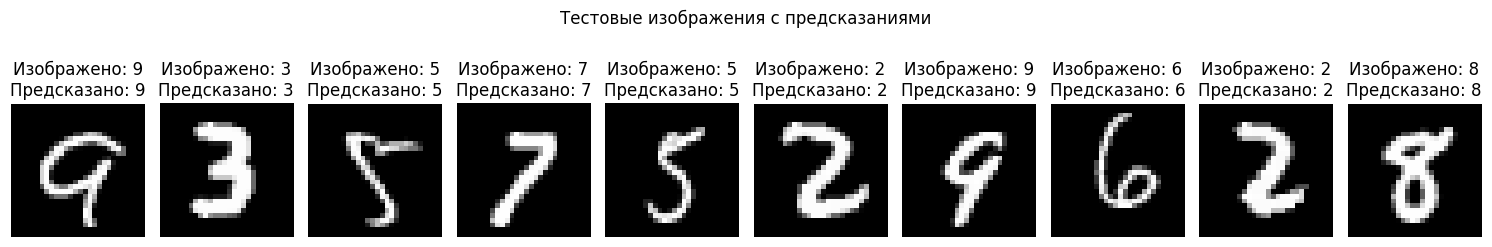

In [20]:
def test_with_visualization(nn, x_test, y_test, num_samples=10):
    nn.forward(x_test)  # Прямое распространение 

    # Выбор случайных изображений
    indices = np.random.choice(len(x_test), size=num_samples, replace=False)
    images_to_plot = x_test[indices].reshape(-1, 28, 28) 
    true_labels = np.argmax(y_test[indices], axis=1)
    predicted_labels = np.argmax(nn.u[indices], axis=1)


    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle('Тестовые изображения с предсказаниями') 
    

    for i, ax in enumerate(axes):
        ax.imshow(images_to_plot[i], cmap='gray')  
        ax.set_title(f'Изображено: {true_labels[i]}\nПредсказано: {predicted_labels[i]}') 
        ax.axis('off')

    plt.tight_layout()
    plt.show() 


test_with_visualization(nn, x_test, y_test, num_samples=10)
